In [1]:
%run train.py

Starting training


[Validation]: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


--- Validation results --- DICE: 0.012387, MSE: 0.327685, KL 7.398737


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


--- Validation results --- DICE: 0.012181, MSE: 0.340386, KL 9.137128


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


--- Validation results --- DICE: 0.012854, MSE: 0.353298, KL 8.386012


[Validation]: 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]


--- Validation results --- DICE: 0.012859, MSE: 0.386487, KL 7.245250


[Validation]: 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


--- Validation results --- DICE: 0.013228, MSE: 0.399769, KL 9.193893


[Validation]: 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


--- Validation results --- DICE: 0.014688, MSE: 0.344263, KL 7.973206


[Validation]: 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


--- Validation results --- DICE: 0.014776, MSE: 0.432298, KL 7.921004


[Validation]: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


--- Validation results --- DICE: 0.014536, MSE: 0.277783, KL 6.999874


[Validation]: 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


--- Validation results --- DICE: 0.015386, MSE: 0.315751, KL 7.315696


[Validation]: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


--- Validation results --- DICE: 0.016265, MSE: 0.327120, KL 8.096696


[Validation]: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


--- Validation results --- DICE: 0.015519, MSE: 0.330565, KL 8.994413


[Validation]: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


--- Validation results --- DICE: 0.017136, MSE: 0.331939, KL 8.131541


[Validation]: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


--- Validation results --- DICE: 0.016259, MSE: 0.402670, KL 6.436495


[Validation]: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


--- Validation results --- DICE: 0.017769, MSE: 0.343674, KL 8.277056


[Validation]: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


--- Validation results --- DICE: 0.017861, MSE: 0.382746, KL 8.656895


[Validation]: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


--- Validation results --- DICE: 0.017999, MSE: 0.351453, KL 8.744903


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


--- Validation results --- DICE: 0.018669, MSE: 0.290116, KL 8.657156


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


--- Validation results --- DICE: 0.019223, MSE: 0.308496, KL 8.584511


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


--- Validation results --- DICE: 0.019815, MSE: 0.335743, KL 6.851501


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


--- Validation results --- DICE: 0.020978, MSE: 0.409791, KL 8.525265


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


--- Validation results --- DICE: 0.021517, MSE: 0.377832, KL 8.432470


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


--- Validation results --- DICE: 0.023611, MSE: 0.309813, KL 8.000133


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


--- Validation results --- DICE: 0.023476, MSE: 0.363330, KL 7.097234


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


--- Validation results --- DICE: 0.024300, MSE: 0.306572, KL 7.040991


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


--- Validation results --- DICE: 0.026114, MSE: 0.282148, KL 7.896213


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


--- Validation results --- DICE: 0.026003, MSE: 0.398676, KL 8.122229


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


--- Validation results --- DICE: 0.026930, MSE: 0.381034, KL 6.961009


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


--- Validation results --- DICE: 0.029319, MSE: 0.378498, KL 7.803388


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


--- Validation results --- DICE: 0.030418, MSE: 0.349082, KL 7.757407


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


--- Validation results --- DICE: 0.031447, MSE: 0.317467, KL 7.834829


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


--- Validation results --- DICE: 0.032019, MSE: 0.311789, KL 6.746475


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


--- Validation results --- DICE: 0.034095, MSE: 0.331440, KL 7.107393


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


--- Validation results --- DICE: 0.034129, MSE: 0.332842, KL 6.584639


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


--- Validation results --- DICE: 0.035504, MSE: 0.285027, KL 6.490079


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


--- Validation results --- DICE: 0.038979, MSE: 0.350388, KL 7.765613


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


--- Validation results --- DICE: 0.038981, MSE: 0.271808, KL 6.770817


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


--- Validation results --- DICE: 0.043119, MSE: 0.279898, KL 7.351285


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


--- Validation results --- DICE: 0.041450, MSE: 0.363969, KL 6.862194


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


--- Validation results --- DICE: 0.046159, MSE: 0.367492, KL 7.246799


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


--- Validation results --- DICE: 0.045368, MSE: 0.310979, KL 7.340253


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


--- Validation results --- DICE: 0.047543, MSE: 0.316866, KL 6.190563


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


--- Validation results --- DICE: 0.050139, MSE: 0.365007, KL 6.156398


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


--- Validation results --- DICE: 0.049165, MSE: 0.329309, KL 6.676600


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


--- Validation results --- DICE: 0.055329, MSE: 0.423327, KL 7.244883


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


--- Validation results --- DICE: 0.054213, MSE: 0.365569, KL 6.083193


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


--- Validation results --- DICE: 0.055101, MSE: 0.281257, KL 6.521792


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


--- Validation results --- DICE: 0.056242, MSE: 0.315918, KL 6.082142


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


--- Validation results --- DICE: 0.056899, MSE: 0.431139, KL 6.130507


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


--- Validation results --- DICE: 0.058715, MSE: 0.330258, KL 6.023045


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


--- Validation results --- DICE: 0.060394, MSE: 0.352052, KL 6.412833


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


--- Validation results --- DICE: 0.064023, MSE: 0.307756, KL 6.447818


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


--- Validation results --- DICE: 0.069843, MSE: 0.400343, KL 6.490121


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


--- Validation results --- DICE: 0.066143, MSE: 0.378610, KL 5.980169


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


--- Validation results --- DICE: 0.073048, MSE: 0.358310, KL 6.196398


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


--- Validation results --- DICE: 0.077501, MSE: 0.335287, KL 6.245063


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


--- Validation results --- DICE: 0.077270, MSE: 0.280140, KL 5.999884


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


--- Validation results --- DICE: 0.073263, MSE: 0.417693, KL 5.955428


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


--- Validation results --- DICE: 0.078242, MSE: 0.299849, KL 6.403540


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


--- Validation results --- DICE: 0.084181, MSE: 0.339951, KL 5.836314


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


--- Validation results --- DICE: 0.081658, MSE: 0.357127, KL 5.931547


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


--- Validation results --- DICE: 0.086078, MSE: 0.291379, KL 5.776334


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


--- Validation results --- DICE: 0.086168, MSE: 0.334579, KL 5.484447


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


--- Validation results --- DICE: 0.087415, MSE: 0.404347, KL 5.479490


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


--- Validation results --- DICE: 0.096124, MSE: 0.362295, KL 5.505127


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


--- Validation results --- DICE: 0.095207, MSE: 0.325515, KL 5.882853


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


--- Validation results --- DICE: 0.091331, MSE: 0.370099, KL 5.245648


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


--- Validation results --- DICE: 0.110404, MSE: 0.293835, KL 5.612391


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


--- Validation results --- DICE: 0.100666, MSE: 0.367410, KL 5.368752


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


--- Validation results --- DICE: 0.103402, MSE: 0.386920, KL 4.824481


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


--- Validation results --- DICE: 0.100905, MSE: 0.311187, KL 4.952727


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


--- Validation results --- DICE: 0.105931, MSE: 0.369145, KL 4.739150


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


--- Validation results --- DICE: 0.113048, MSE: 0.401759, KL 5.234858


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


--- Validation results --- DICE: 0.101467, MSE: 0.292024, KL 4.778829


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


--- Validation results --- DICE: 0.096838, MSE: 0.381681, KL 4.789198


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.67it/s]


--- Validation results --- DICE: 0.099555, MSE: 0.293376, KL 5.340331


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


--- Validation results --- DICE: 0.109360, MSE: 0.340137, KL 5.048724


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


--- Validation results --- DICE: 0.102317, MSE: 0.311939, KL 4.580211


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


--- Validation results --- DICE: 0.097652, MSE: 0.365935, KL 5.206981


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


--- Validation results --- DICE: 0.100097, MSE: 0.326358, KL 4.508080


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


--- Validation results --- DICE: 0.105170, MSE: 0.420887, KL 4.823190


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


--- Validation results --- DICE: 0.099702, MSE: 0.400302, KL 4.770791


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


--- Validation results --- DICE: 0.096326, MSE: 0.337846, KL 4.477522


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


--- Validation results --- DICE: 0.096240, MSE: 0.397881, KL 4.906029


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


--- Validation results --- DICE: 0.092387, MSE: 0.414120, KL 4.425662


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


--- Validation results --- DICE: 0.096668, MSE: 0.283308, KL 4.775346


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


--- Validation results --- DICE: 0.100884, MSE: 0.358075, KL 4.565977


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


--- Validation results --- DICE: 0.105475, MSE: 0.320530, KL 4.555414


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


--- Validation results --- DICE: 0.098274, MSE: 0.409010, KL 4.568895


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


--- Validation results --- DICE: 0.099750, MSE: 0.353687, KL 4.685679


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


--- Validation results --- DICE: 0.099303, MSE: 0.379768, KL 4.659916


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


--- Validation results --- DICE: 0.096717, MSE: 0.407004, KL 4.194373


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


--- Validation results --- DICE: 0.104675, MSE: 0.274873, KL 4.430316


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


--- Validation results --- DICE: 0.100734, MSE: 0.355117, KL 4.562833


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


--- Validation results --- DICE: 0.094940, MSE: 0.284591, KL 4.169689


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


--- Validation results --- DICE: 0.101104, MSE: 0.316966, KL 4.299059


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


--- Validation results --- DICE: 0.105665, MSE: 0.303796, KL 4.315771


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


--- Validation results --- DICE: 0.103340, MSE: 0.376042, KL 4.303691


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


--- Validation results --- DICE: 0.104052, MSE: 0.351144, KL 4.413700


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


--- Validation results --- DICE: 0.107328, MSE: 0.331624, KL 4.240785


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


--- Validation results --- DICE: 0.099897, MSE: 0.280705, KL 4.583387


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


--- Validation results --- DICE: 0.100216, MSE: 0.288960, KL 3.963869


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


--- Validation results --- DICE: 0.098156, MSE: 0.353448, KL 3.951068


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


--- Validation results --- DICE: 0.103245, MSE: 0.423519, KL 4.124536


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s]


--- Validation results --- DICE: 0.101544, MSE: 0.403601, KL 4.141032


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


--- Validation results --- DICE: 0.090555, MSE: 0.398986, KL 3.994947


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


--- Validation results --- DICE: 0.096956, MSE: 0.352139, KL 4.301659


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


--- Validation results --- DICE: 0.091097, MSE: 0.364233, KL 3.935987


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


--- Validation results --- DICE: 0.091741, MSE: 0.310432, KL 4.444124


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


--- Validation results --- DICE: 0.091269, MSE: 0.368553, KL 4.403800


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s]


--- Validation results --- DICE: 0.092455, MSE: 0.419968, KL 3.847623


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


--- Validation results --- DICE: 0.087390, MSE: 0.360596, KL 3.894650


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


--- Validation results --- DICE: 0.087702, MSE: 0.374011, KL 4.190901


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


--- Validation results --- DICE: 0.090929, MSE: 0.348430, KL 3.822800


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


--- Validation results --- DICE: 0.091779, MSE: 0.320298, KL 4.015725


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


--- Validation results --- DICE: 0.086949, MSE: 0.309473, KL 4.318141


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


--- Validation results --- DICE: 0.088159, MSE: 0.358004, KL 4.264311


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


--- Validation results --- DICE: 0.094979, MSE: 0.363626, KL 3.961416


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


--- Validation results --- DICE: 0.091323, MSE: 0.337043, KL 3.944422


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


--- Validation results --- DICE: 0.086619, MSE: 0.319954, KL 4.235376


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


--- Validation results --- DICE: 0.084576, MSE: 0.325903, KL 3.732887


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


--- Validation results --- DICE: 0.090283, MSE: 0.386872, KL 3.886969


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


--- Validation results --- DICE: 0.091775, MSE: 0.380265, KL 3.871070


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


--- Validation results --- DICE: 0.089627, MSE: 0.320700, KL 3.704988


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


--- Validation results --- DICE: 0.084027, MSE: 0.338900, KL 3.674089


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


--- Validation results --- DICE: 0.092498, MSE: 0.305618, KL 3.889993


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


--- Validation results --- DICE: 0.087989, MSE: 0.299306, KL 4.047759


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


--- Validation results --- DICE: 0.089016, MSE: 0.314964, KL 3.864901


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


--- Validation results --- DICE: 0.084309, MSE: 0.397657, KL 3.823341


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


--- Validation results --- DICE: 0.076532, MSE: 0.389347, KL 4.011826


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


--- Validation results --- DICE: 0.075465, MSE: 0.388251, KL 4.013742


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


--- Validation results --- DICE: 0.075552, MSE: 0.326808, KL 3.978307


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


--- Validation results --- DICE: 0.082636, MSE: 0.385455, KL 3.788485


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


--- Validation results --- DICE: 0.077453, MSE: 0.329357, KL 4.072542


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


--- Validation results --- DICE: 0.074590, MSE: 0.293634, KL 3.634594


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


--- Validation results --- DICE: 0.073593, MSE: 0.361916, KL 3.628023


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


--- Validation results --- DICE: 0.078861, MSE: 0.279171, KL 3.715847


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


--- Validation results --- DICE: 0.077166, MSE: 0.350773, KL 3.643995


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


--- Validation results --- DICE: 0.080140, MSE: 0.311009, KL 3.942007


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


--- Validation results --- DICE: 0.083158, MSE: 0.294399, KL 3.778357


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


--- Validation results --- DICE: 0.083963, MSE: 0.372645, KL 3.715906


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


--- Validation results --- DICE: 0.075514, MSE: 0.326343, KL 3.847517


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


--- Validation results --- DICE: 0.077105, MSE: 0.286319, KL 3.813633


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


--- Validation results --- DICE: 0.079939, MSE: 0.373445, KL 3.656823


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


--- Validation results --- DICE: 0.079501, MSE: 0.318997, KL 3.584230


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


--- Validation results --- DICE: 0.081934, MSE: 0.313345, KL 3.625130


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


--- Validation results --- DICE: 0.078696, MSE: 0.354270, KL 3.504149


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


--- Validation results --- DICE: 0.076624, MSE: 0.436199, KL 3.507111


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


--- Validation results --- DICE: 0.079278, MSE: 0.398630, KL 3.547922


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


--- Validation results --- DICE: 0.079890, MSE: 0.276456, KL 3.538888


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


--- Validation results --- DICE: 0.085890, MSE: 0.319595, KL 3.627151


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


--- Validation results --- DICE: 0.080530, MSE: 0.281553, KL 3.547393


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


--- Validation results --- DICE: 0.079903, MSE: 0.387812, KL 3.811929


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


--- Validation results --- DICE: 0.075704, MSE: 0.358927, KL 3.365947


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


--- Validation results --- DICE: 0.075501, MSE: 0.342658, KL 3.697782


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


--- Validation results --- DICE: 0.078100, MSE: 0.346894, KL 3.500730


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


--- Validation results --- DICE: 0.074884, MSE: 0.387397, KL 3.439062


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


--- Validation results --- DICE: 0.072434, MSE: 0.423427, KL 3.319217


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


--- Validation results --- DICE: 0.075241, MSE: 0.414865, KL 3.493602


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


--- Validation results --- DICE: 0.071729, MSE: 0.312072, KL 3.641713


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


--- Validation results --- DICE: 0.077027, MSE: 0.297261, KL 3.706605


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


--- Validation results --- DICE: 0.072553, MSE: 0.330434, KL 3.411574


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


--- Validation results --- DICE: 0.071077, MSE: 0.387505, KL 3.642873


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


--- Validation results --- DICE: 0.080762, MSE: 0.374651, KL 3.488936


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


--- Validation results --- DICE: 0.074996, MSE: 0.379359, KL 3.458872


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


--- Validation results --- DICE: 0.071426, MSE: 0.309184, KL 3.277742


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


--- Validation results --- DICE: 0.077560, MSE: 0.320904, KL 3.653578


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


--- Validation results --- DICE: 0.081706, MSE: 0.364141, KL 3.455116


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


--- Validation results --- DICE: 0.075347, MSE: 0.356982, KL 3.402319


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


--- Validation results --- DICE: 0.071444, MSE: 0.403332, KL 3.219508


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


--- Validation results --- DICE: 0.084402, MSE: 0.293364, KL 3.440630


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


--- Validation results --- DICE: 0.076717, MSE: 0.330326, KL 3.358018


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


--- Validation results --- DICE: 0.075777, MSE: 0.340380, KL 3.349405


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


--- Validation results --- DICE: 0.075421, MSE: 0.382067, KL 3.353665


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


--- Validation results --- DICE: 0.070987, MSE: 0.408543, KL 3.330170


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.23it/s]


--- Validation results --- DICE: 0.073850, MSE: 0.316112, KL 3.602674


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


--- Validation results --- DICE: 0.073172, MSE: 0.417477, KL 3.585885


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.67it/s]


--- Validation results --- DICE: 0.069057, MSE: 0.341072, KL 3.512475


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


--- Validation results --- DICE: 0.077775, MSE: 0.310341, KL 3.397714


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s]


--- Validation results --- DICE: 0.070549, MSE: 0.358176, KL 3.358612


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


--- Validation results --- DICE: 0.072267, MSE: 0.423258, KL 3.551216


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


--- Validation results --- DICE: 0.071348, MSE: 0.363954, KL 3.341659


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


--- Validation results --- DICE: 0.072728, MSE: 0.376619, KL 3.270997


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


--- Validation results --- DICE: 0.069624, MSE: 0.408939, KL 3.087098


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


--- Validation results --- DICE: 0.071604, MSE: 0.333115, KL 3.249633


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


--- Validation results --- DICE: 0.074594, MSE: 0.361123, KL 3.248767


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


--- Validation results --- DICE: 0.069970, MSE: 0.377710, KL 3.459228


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


--- Validation results --- DICE: 0.074832, MSE: 0.336791, KL 3.476524


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


--- Validation results --- DICE: 0.071319, MSE: 0.293274, KL 3.408336


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


--- Validation results --- DICE: 0.074922, MSE: 0.304645, KL 3.457398


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


--- Validation results --- DICE: 0.072831, MSE: 0.365303, KL 3.216804


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


--- Validation results --- DICE: 0.073008, MSE: 0.277475, KL 3.474714


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


--- Validation results --- DICE: 0.076779, MSE: 0.392789, KL 3.265595


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


--- Validation results --- DICE: 0.069689, MSE: 0.396171, KL 3.209670


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


--- Validation results --- DICE: 0.068948, MSE: 0.335254, KL 3.257261


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


--- Validation results --- DICE: 0.074139, MSE: 0.401450, KL 3.257331


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


--- Validation results --- DICE: 0.066191, MSE: 0.323617, KL 3.046101


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


--- Validation results --- DICE: 0.070094, MSE: 0.339651, KL 3.413291


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


--- Validation results --- DICE: 0.066710, MSE: 0.360352, KL 3.200800


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


--- Validation results --- DICE: 0.066404, MSE: 0.381213, KL 2.993978


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


--- Validation results --- DICE: 0.070028, MSE: 0.314851, KL 3.434000


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


--- Validation results --- DICE: 0.067476, MSE: 0.357020, KL 2.980141


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


--- Validation results --- DICE: 0.071188, MSE: 0.297688, KL 3.177460


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.25it/s]


--- Validation results --- DICE: 0.072058, MSE: 0.298250, KL 3.072870


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


--- Validation results --- DICE: 0.072677, MSE: 0.293479, KL 3.065731


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


--- Validation results --- DICE: 0.072290, MSE: 0.359420, KL 3.163400


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


--- Validation results --- DICE: 0.073279, MSE: 0.297434, KL 3.311888


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


--- Validation results --- DICE: 0.073662, MSE: 0.387668, KL 3.317968


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


--- Validation results --- DICE: 0.069783, MSE: 0.279405, KL 3.244229


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


--- Validation results --- DICE: 0.073364, MSE: 0.400117, KL 3.303885


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


--- Validation results --- DICE: 0.073288, MSE: 0.335105, KL 3.285586


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.29it/s]


--- Validation results --- DICE: 0.071977, MSE: 0.338424, KL 3.033961


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.29it/s]


--- Validation results --- DICE: 0.071793, MSE: 0.294615, KL 3.021127


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.20it/s]


--- Validation results --- DICE: 0.072410, MSE: 0.368269, KL 3.263526


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


--- Validation results --- DICE: 0.069275, MSE: 0.267291, KL 3.058922


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s]


--- Validation results --- DICE: 0.072114, MSE: 0.317944, KL 3.245266


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.23it/s]


--- Validation results --- DICE: 0.067988, MSE: 0.305538, KL 3.190444


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


--- Validation results --- DICE: 0.071103, MSE: 0.306635, KL 3.233212


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


--- Validation results --- DICE: 0.068111, MSE: 0.347316, KL 3.087859


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


--- Validation results --- DICE: 0.065007, MSE: 0.398638, KL 2.868871


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]


--- Validation results --- DICE: 0.064982, MSE: 0.427834, KL 2.855896


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


--- Validation results --- DICE: 0.070859, MSE: 0.356124, KL 3.295172


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


--- Validation results --- DICE: 0.067668, MSE: 0.300523, KL 3.146830


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


--- Validation results --- DICE: 0.068979, MSE: 0.373250, KL 3.010530


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


--- Validation results --- DICE: 0.076955, MSE: 0.345219, KL 3.040706


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


--- Validation results --- DICE: 0.073445, MSE: 0.293743, KL 3.168948


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


--- Validation results --- DICE: 0.069495, MSE: 0.369811, KL 3.031809


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


--- Validation results --- DICE: 0.067666, MSE: 0.291811, KL 2.808285


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


--- Validation results --- DICE: 0.072975, MSE: 0.290466, KL 3.221503


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


--- Validation results --- DICE: 0.072189, MSE: 0.419289, KL 3.227467


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


--- Validation results --- DICE: 0.068662, MSE: 0.385626, KL 3.097453


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


--- Validation results --- DICE: 0.072009, MSE: 0.281884, KL 2.917803


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


--- Validation results --- DICE: 0.073813, MSE: 0.318463, KL 3.128716


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


--- Validation results --- DICE: 0.066869, MSE: 0.422366, KL 2.770944


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


--- Validation results --- DICE: 0.068222, MSE: 0.322562, KL 2.962837


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


--- Validation results --- DICE: 0.069580, MSE: 0.375818, KL 3.214893


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


--- Validation results --- DICE: 0.074713, MSE: 0.381999, KL 2.975326


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


--- Validation results --- DICE: 0.066053, MSE: 0.311665, KL 2.764770


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


--- Validation results --- DICE: 0.069856, MSE: 0.391355, KL 3.197429


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


--- Validation results --- DICE: 0.067206, MSE: 0.295307, KL 2.759352


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


--- Validation results --- DICE: 0.068779, MSE: 0.359566, KL 2.944166


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


--- Validation results --- DICE: 0.066831, MSE: 0.303649, KL 2.747388


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


--- Validation results --- DICE: 0.066770, MSE: 0.304930, KL 2.738704


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


--- Validation results --- DICE: 0.067499, MSE: 0.359754, KL 2.739501


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


--- Validation results --- DICE: 0.070228, MSE: 0.298580, KL 2.870103


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


--- Validation results --- DICE: 0.069110, MSE: 0.383529, KL 2.882896


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


--- Validation results --- DICE: 0.068876, MSE: 0.308722, KL 2.906654


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


--- Validation results --- DICE: 0.076277, MSE: 0.364388, KL 2.897190


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


--- Validation results --- DICE: 0.076531, MSE: 0.385496, KL 2.885253


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


--- Validation results --- DICE: 0.075909, MSE: 0.387826, KL 2.879018


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


--- Validation results --- DICE: 0.068776, MSE: 0.332954, KL 2.990980


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


--- Validation results --- DICE: 0.066881, MSE: 0.323319, KL 2.870941


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.29it/s]


--- Validation results --- DICE: 0.068136, MSE: 0.345402, KL 2.981721


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


--- Validation results --- DICE: 0.065911, MSE: 0.338149, KL 2.865281


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


--- Validation results --- DICE: 0.071428, MSE: 0.283025, KL 3.020427


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


--- Validation results --- DICE: 0.068768, MSE: 0.320737, KL 2.812960


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


--- Validation results --- DICE: 0.070909, MSE: 0.305372, KL 3.010588


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


--- Validation results --- DICE: 0.065574, MSE: 0.351428, KL 2.844268


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


--- Validation results --- DICE: 0.065292, MSE: 0.416696, KL 2.858978


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


--- Validation results --- DICE: 0.069113, MSE: 0.312209, KL 3.031509


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


--- Validation results --- DICE: 0.073993, MSE: 0.369245, KL 2.812652


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]


--- Validation results --- DICE: 0.070590, MSE: 0.290749, KL 2.989615


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]


--- Validation results --- DICE: 0.073147, MSE: 0.394504, KL 2.803072


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


--- Validation results --- DICE: 0.066053, MSE: 0.364564, KL 2.838625


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


--- Validation results --- DICE: 0.067113, MSE: 0.326804, KL 3.016444


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


--- Validation results --- DICE: 0.064055, MSE: 0.296374, KL 2.610492


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


--- Validation results --- DICE: 0.065799, MSE: 0.365364, KL 2.753854


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


--- Validation results --- DICE: 0.064336, MSE: 0.361805, KL 2.907238


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


--- Validation results --- DICE: 0.067104, MSE: 0.287924, KL 2.986825


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


--- Validation results --- DICE: 0.070799, MSE: 0.312525, KL 2.796317


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


--- Validation results --- DICE: 0.062792, MSE: 0.387652, KL 2.811632


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


--- Validation results --- DICE: 0.063730, MSE: 0.385666, KL 2.885175


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


--- Validation results --- DICE: 0.067654, MSE: 0.304177, KL 2.935803


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


--- Validation results --- DICE: 0.063210, MSE: 0.360691, KL 2.796875


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


--- Validation results --- DICE: 0.067062, MSE: 0.374135, KL 2.934784


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


--- Validation results --- DICE: 0.066215, MSE: 0.331013, KL 2.957334


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


--- Validation results --- DICE: 0.071722, MSE: 0.396826, KL 2.743495


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


--- Validation results --- DICE: 0.066051, MSE: 0.291825, KL 2.766717


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


--- Validation results --- DICE: 0.071665, MSE: 0.384782, KL 2.736835


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


--- Validation results --- DICE: 0.066390, MSE: 0.302027, KL 2.755694


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


--- Validation results --- DICE: 0.063721, MSE: 0.410939, KL 2.547580


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


--- Validation results --- DICE: 0.068047, MSE: 0.352821, KL 2.893739


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


--- Validation results --- DICE: 0.066159, MSE: 0.310867, KL 2.736255


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


--- Validation results --- DICE: 0.064795, MSE: 0.312785, KL 2.731740


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


--- Validation results --- DICE: 0.066346, MSE: 0.400432, KL 2.667104


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


--- Validation results --- DICE: 0.068615, MSE: 0.401503, KL 2.875265


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


--- Validation results --- DICE: 0.067109, MSE: 0.281211, KL 2.715628


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


--- Validation results --- DICE: 0.064137, MSE: 0.413120, KL 2.510866


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


--- Validation results --- DICE: 0.066747, MSE: 0.349278, KL 2.647092


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


--- Validation results --- DICE: 0.065891, MSE: 0.331426, KL 2.698777


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


--- Validation results --- DICE: 0.065881, MSE: 0.299831, KL 2.624935


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


--- Validation results --- DICE: 0.064905, MSE: 0.347845, KL 2.713247


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


--- Validation results --- DICE: 0.072942, MSE: 0.276575, KL 2.709235


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


--- Validation results --- DICE: 0.065764, MSE: 0.390975, KL 2.678738


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


--- Validation results --- DICE: 0.071316, MSE: 0.329194, KL 2.684449


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


--- Validation results --- DICE: 0.063162, MSE: 0.297664, KL 2.691377


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


--- Validation results --- DICE: 0.065990, MSE: 0.348517, KL 2.818624


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


--- Validation results --- DICE: 0.062448, MSE: 0.356100, KL 2.776217


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


--- Validation results --- DICE: 0.069925, MSE: 0.299124, KL 2.677295


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


--- Validation results --- DICE: 0.069657, MSE: 0.369351, KL 2.658783


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


--- Validation results --- DICE: 0.062751, MSE: 0.405624, KL 2.462078


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


--- Validation results --- DICE: 0.063980, MSE: 0.416307, KL 2.643713


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


--- Validation results --- DICE: 0.064271, MSE: 0.298732, KL 2.758769


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


--- Validation results --- DICE: 0.063363, MSE: 0.387254, KL 2.654520


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


--- Validation results --- DICE: 0.064098, MSE: 0.318101, KL 2.636339


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


--- Validation results --- DICE: 0.064127, MSE: 0.401646, KL 2.640349


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


--- Validation results --- DICE: 0.064522, MSE: 0.331081, KL 2.743900


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


--- Validation results --- DICE: 0.064674, MSE: 0.334068, KL 2.737725


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


--- Validation results --- DICE: 0.064503, MSE: 0.322796, KL 2.737039


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


--- Validation results --- DICE: 0.064739, MSE: 0.362088, KL 2.413070


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


--- Validation results --- DICE: 0.067899, MSE: 0.393311, KL 2.795959


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


--- Validation results --- DICE: 0.064672, MSE: 0.286692, KL 2.399913


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


--- Validation results --- DICE: 0.065360, MSE: 0.342213, KL 2.594279


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


--- Validation results --- DICE: 0.063563, MSE: 0.396046, KL 2.399844


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


--- Validation results --- DICE: 0.065400, MSE: 0.319868, KL 2.588730


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


--- Validation results --- DICE: 0.066209, MSE: 0.281199, KL 2.770766


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


--- Validation results --- DICE: 0.063715, MSE: 0.359299, KL 2.684872


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


--- Validation results --- DICE: 0.064659, MSE: 0.323202, KL 2.578001


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


--- Validation results --- DICE: 0.064533, MSE: 0.338173, KL 2.574125


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


--- Validation results --- DICE: 0.064047, MSE: 0.383448, KL 2.568050


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


--- Validation results --- DICE: 0.065806, MSE: 0.293761, KL 2.563770


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


--- Validation results --- DICE: 0.067548, MSE: 0.330840, KL 2.696975


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


--- Validation results --- DICE: 0.065453, MSE: 0.298564, KL 2.558215


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


--- Validation results --- DICE: 0.066511, MSE: 0.384187, KL 2.487222


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


--- Validation results --- DICE: 0.068561, MSE: 0.356899, KL 2.736028


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]


--- Validation results --- DICE: 0.074196, MSE: 0.315473, KL 2.538315


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


--- Validation results --- DICE: 0.066034, MSE: 0.286888, KL 2.640408


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]


--- Validation results --- DICE: 0.069133, MSE: 0.294756, KL 2.710243


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


--- Validation results --- DICE: 0.073966, MSE: 0.318592, KL 2.527128


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


--- Validation results --- DICE: 0.066218, MSE: 0.369738, KL 2.522155


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


--- Validation results --- DICE: 0.074858, MSE: 0.297102, KL 2.518723


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


--- Validation results --- DICE: 0.067894, MSE: 0.395722, KL 2.490406


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


--- Validation results --- DICE: 0.067033, MSE: 0.391429, KL 2.608140


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


--- Validation results --- DICE: 0.068278, MSE: 0.322178, KL 2.432997


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


--- Validation results --- DICE: 0.066945, MSE: 0.361879, KL 2.605063


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


--- Validation results --- DICE: 0.066914, MSE: 0.319041, KL 2.301426


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


--- Validation results --- DICE: 0.069598, MSE: 0.370343, KL 2.634407


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


--- Validation results --- DICE: 0.065539, MSE: 0.405677, KL 2.288879


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


--- Validation results --- DICE: 0.072391, MSE: 0.390313, KL 2.465473


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


--- Validation results --- DICE: 0.071880, MSE: 0.401965, KL 2.461843


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


--- Validation results --- DICE: 0.069536, MSE: 0.278333, KL 2.614665


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


--- Validation results --- DICE: 0.067814, MSE: 0.324154, KL 2.390098


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


--- Validation results --- DICE: 0.071739, MSE: 0.330815, KL 2.455744


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


--- Validation results --- DICE: 0.066531, MSE: 0.364106, KL 2.642929


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


--- Validation results --- DICE: 0.063653, MSE: 0.387983, KL 2.565427


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


--- Validation results --- DICE: 0.063847, MSE: 0.364012, KL 2.559222


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


--- Validation results --- DICE: 0.063274, MSE: 0.342889, KL 2.264357


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


--- Validation results --- DICE: 0.066316, MSE: 0.361820, KL 2.619039


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


--- Validation results --- DICE: 0.062604, MSE: 0.407939, KL 2.452173


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


--- Validation results --- DICE: 0.063888, MSE: 0.389256, KL 2.370200


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


--- Validation results --- DICE: 0.065433, MSE: 0.423286, KL 2.599858


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


--- Validation results --- DICE: 0.064146, MSE: 0.405828, KL 2.361801


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


--- Validation results --- DICE: 0.063514, MSE: 0.343346, KL 2.241747


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


--- Validation results --- DICE: 0.064355, MSE: 0.315592, KL 2.240242


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


--- Validation results --- DICE: 0.063074, MSE: 0.363552, KL 2.232774


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


--- Validation results --- DICE: 0.067602, MSE: 0.291194, KL 2.548711


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


--- Validation results --- DICE: 0.063335, MSE: 0.388930, KL 2.408972


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


--- Validation results --- DICE: 0.064846, MSE: 0.315410, KL 2.327436


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


--- Validation results --- DICE: 0.063139, MSE: 0.369625, KL 2.400203


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


--- Validation results --- DICE: 0.062740, MSE: 0.389266, KL 2.211687


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


--- Validation results --- DICE: 0.063858, MSE: 0.387296, KL 2.393651


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


--- Validation results --- DICE: 0.062700, MSE: 0.403785, KL 2.393620


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


--- Validation results --- DICE: 0.069985, MSE: 0.347376, KL 2.378314


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


--- Validation results --- DICE: 0.062775, MSE: 0.344778, KL 2.207408


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


--- Validation results --- DICE: 0.065943, MSE: 0.399027, KL 2.535357


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


--- Validation results --- DICE: 0.064972, MSE: 0.284002, KL 2.534045


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


--- Validation results --- DICE: 0.069406, MSE: 0.365240, KL 2.362920


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


--- Validation results --- DICE: 0.070356, MSE: 0.381045, KL 2.358474


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]


--- Validation results --- DICE: 0.062559, MSE: 0.378812, KL 2.488005


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


--- Validation results --- DICE: 0.062065, MSE: 0.401832, KL 2.368626


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


--- Validation results --- DICE: 0.064721, MSE: 0.306785, KL 2.293902


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


--- Validation results --- DICE: 0.072168, MSE: 0.300596, KL 2.348316


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


--- Validation results --- DICE: 0.066890, MSE: 0.298076, KL 2.501007


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


--- Validation results --- DICE: 0.063117, MSE: 0.411245, KL 2.468638


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


--- Validation results --- DICE: 0.063461, MSE: 0.308232, KL 2.350465


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


--- Validation results --- DICE: 0.064762, MSE: 0.350945, KL 2.360193


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


--- Validation results --- DICE: 0.066483, MSE: 0.320959, KL 2.493494


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


--- Validation results --- DICE: 0.064145, MSE: 0.342866, KL 2.266817


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


--- Validation results --- DICE: 0.063714, MSE: 0.367095, KL 2.338586


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


--- Validation results --- DICE: 0.063400, MSE: 0.309501, KL 2.330521


[Validation]: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


--- Validation results --- DICE: 0.062904, MSE: 0.378838, KL 2.447534


KeyboardInterrupt: 

In [3]:
import sys
from tqdm import tqdm
from src.data_preparation import *
from src.network import *
from src.criterion import *
from src.testing_functions import *
from torch.optim.lr_scheduler import LambdaLR
from pathlib import Path

#=========== SETUP PARAMETERS ===============

label = "test1"
num_slices = 3
downsamp_type = 'bilinear'
ds_ratio = 2

num_epochs = 100
learning_rate = 1e-4
batch_size = 1
validation = True
save_model_each_epoch = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_path = '../BRATS20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
results_path = Path('training_results')/label
results_path.mkdir(parents=True, exist_ok=True)

validation_metrics = np.zeros((num_epochs,3))

#=========== SETUP DATASETS AND DATA LOADERS ===============

dataset = BRATS_dataset(data_path, device, num_slices = num_slices, ds_ratio = ds_ratio, downsamp_type = downsamp_type, num_volumes = 100)

# Determine Split Ratios
train_ratio = 0.7
val_ratio = 0.15

train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size # Ensure sum equals total_samples

# For reproducibility, set a random seed
g = torch.Generator().manual_seed(42) 
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=g
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)


checkpoint_path = f"training_results/{label}/checkpoint.pth.tar"
checkpoint = torch.load(checkpoint_path)

model = VAE_UNET(num_slices, input_dim=dataset.input_dim, HR_dim=dataset.output_dim)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)


(100, 3)


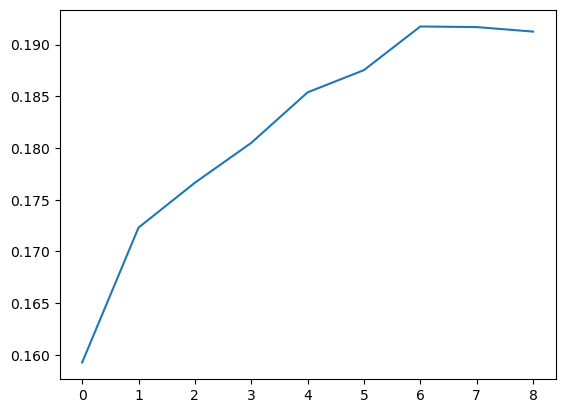

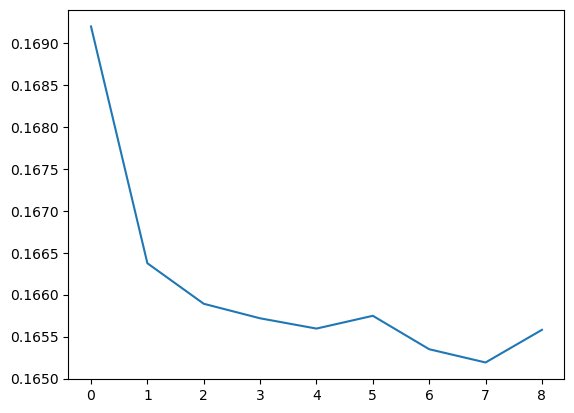

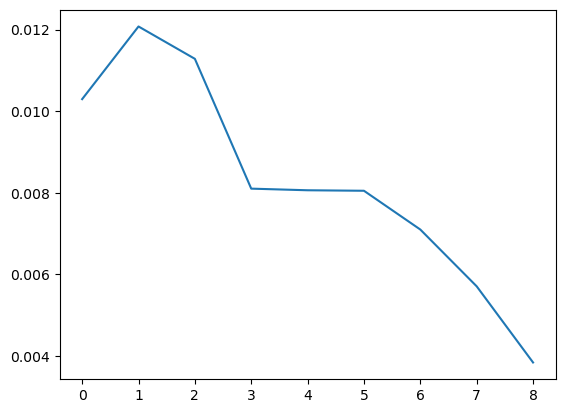

In [9]:
import numpy as np
import matplotlib.pyplot as plt
# slices = [330]
# save_path = Path("training_results")
# plot_examples(model, test_dataset, slices, results_path)

metrics = np.load(results_path/"training_metrics.npy")

print(metrics.shape)

plt.figure()
plt.plot(metrics[0:9,0])
plt.show()


plt.figure()
plt.plot(metrics[0:9,1])
plt.show()

plt.figure()
plt.plot(metrics[0:9,2])
plt.show()